# Bird Species Classification:
### Using Computer Vision to Classify 525 Different Bird Species
By: David Hartsman

<hr style="border: 4px solid blue">

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import pandas as pd
import os

import tensorflow as tf
# To streamline the naming, batch generation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Keras model types and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend
from tensorflow import keras

# Metrics for classification
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Recall, Precision

import wandb
from wandb.keras import WandbCallback

import warnings
warnings.filterwarnings("ignore")

2024-02-11 16:22:09.823372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Local path containing train/valid/test folders

path = "/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive"

# 1st set of parameters for model that achieved 44% accuracy after 20 epochs of training
# image_generator = ImageDataGenerator(
#     rescale=1./255,  # Normalize pixel values to [0,1]
#     rotation_range=20,  # Randomly rotate images by up to 20 degrees
#     width_shift_range=0.2,  # Randomly shift images horizontally
#     height_shift_range=0.2,  # Randomly shift images vertically
#     shear_range=0.2,  # Shear intensity
#     zoom_range=0.2,  # Randomly zoom images
#     horizontal_flip=True,  # Randomly flip images horizontally
#     fill_mode='nearest'  # Fill in missing pixels with the nearest value

# Default values except for 'rescale', validation_split == 0 because we have separate validation data

image_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rescale=1/255,  # This argument is still being utilized to scale data from 0 - 1
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode="nearest",  # still the same
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None)


In [3]:
# Train Generator
train_generator = image_generator.flow_from_directory(
    directory=os.path.join(path, "train"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    seed=13
)

# Validation
valid_generator = image_generator.flow_from_directory(
    directory=os.path.join(path, "valid"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    seed=13
)

#Test
test_generator = image_generator.flow_from_directory(
    directory=os.path.join(path, "test"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    seed=13
)

## Docstring defaults
# image_generator.flow_from_directory(
#     directory,
#     target_size=(256, 256),
#     color_mode='rgb',
#     classes=None,
#     class_mode='categorical',
#     batch_size=32,
#     shuffle=True,
#     seed=None,
#     save_to_dir=None,
#     save_prefix='',
#     save_format='png',
#     follow_links=False,
#     subset=None,
#     interpolation='nearest',
#     keep_aspect_ratio=False,

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [4]:
# The labels for the image data
class_indices = train_generator.class_indices
reverse_dict = {val:key for key, val in class_indices.items()}

In [5]:
# Verifying dictionary construction
class_indices["OILBIRD"], reverse_dict[366],

(366, 'OILBIRD')

<hr style="border: 2px solid blue">

### Keras Convolutional Neural Netword Model Creation

In [6]:
# Instantiate sequential model
model = Sequential()

# Add convolutional layer with pooling
model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1,1), input_shape=(224,224,3), activation="relu"))
model.add(MaxPooling2D())

# 2nd convolutional layer
model.add(Conv2D(12, (2,2), (1,1), activation="relu"))
model.add(MaxPooling2D())

# Flatten into a scaler
model.add(Flatten())

# Dense layer
model.add(Dense(192, activation = 'relu'))

# Dense output layer
model.add(Dense(525, activation="softmax"))

2024-02-09 21:56:22.595318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Model Compilation

model.compile(optimizer="adam", loss="categorical_crossentropy", \
              metrics=["accuracy"])

In [8]:
# Summary of the Model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 12)      780       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 12)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 36300)             0         
                                                                 
 dense (Dense)               (None, 192)               6

In [9]:
# Fitting the model

histoy = model.fit(train_generator, epochs=20, validation_data=valid_generator, workers=6)


# 1st model from previous notebook
# hist = model.fit(data_generator, epochs=20, validation_data=valid_generator, callbacks=[tensorboard_callback],\
#                  workers=6)

Epoch 1/20
2645/2645 [==============================] - 787s 297ms/step - loss: 4.8926 - accuracy: 0.0928 - val_loss: 3.7699 - val_accuracy: 0.2168
Epoch 2/20
2645/2645 [==============================] - 1582s 598ms/step - loss: 3.5795 - accuracy: 0.2493 - val_loss: 3.2601 - val_accuracy: 0.2907
Epoch 3/20
2645/2645 [==============================] - 765s 289ms/step - loss: 3.0663 - accuracy: 0.3320 - val_loss: 3.0430 - val_accuracy: 0.3280
Epoch 4/20
2645/2645 [==============================] - 912s 345ms/step - loss: 2.6965 - accuracy: 0.3948 - val_loss: 3.1217 - val_accuracy: 0.3295
Epoch 5/20
2645/2645 [==============================] - 790s 299ms/step - loss: 2.3589 - accuracy: 0.4529 - val_loss: 3.0393 - val_accuracy: 0.3417
Epoch 6/20
2645/2645 [==============================] - 890s 336ms/step - loss: 2.0273 - accuracy: 0.5147 - val_loss: 3.2241 - val_accuracy: 0.3272
Epoch 7/20
2645/2645 [==============================] - 785s 297ms/step - loss: 1.7102 - accuracy: 0.5767 - val

In [137]:
# Saving the second model
histoy.model.save('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/models/bird_classifier_2.h5')

<hr style="border: 3px solid blue">

### Stripped-down model evaluation:
This model clearly suffers from over-fitting. While my initial model topped out in the 40%s for training and validation accuracy, the model generalized in parallel with its training performance. For this model, the training accuracy was around 70% higher than its validation accuracy. This is unacceptably over-fit, and is indicative of a model with terribly generalization capability. This model is effectively unusable. 

In [78]:
# Creating a df from this model's training history object

model_df = pd.DataFrame(histoy.history)
model_df["Epochs"] = range(1, 21)
model_df["Name"] = "Model 2"
# model_df.to_csv('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_2_logs.csv')
# model_df = pd.read_csv('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_2_logs.csv', index_col=0)
model_df.head()

,loss,accuracy,val_loss,val_accuracy,Epochs,Name
0,4.892591,0.092846,3.769941,0.216762,1,Model 2
1,3.579454,0.249282,3.260067,0.290667,2,Model 2
2,3.066257,0.332038,3.042955,0.328000,3,Model 2
3,2.696495,0.394789,3.121729,0.329524,4,Model 2
4,2.358895,0.452933,3.039319,0.341714,5,Model 2


In [30]:
# Importing data from the model created in the previous notebook

first_model = pd.read_csv('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_1_logs.csv', index_col=0)
first_model["Name"] = "Model 1"
first_model = first_model.reindex(columns=model_df.columns)
first_model.head()

,loss,accuracy,val_loss,val_accuracy,Epochs,Name
0,5.677375,0.020193,5.195110,0.044571,1,Model 1
1,4.914515,0.075772,4.407012,0.119619,2,Model 1
2,4.315264,0.145401,4.062500,0.180571,3,Model 1
3,3.901346,0.202280,3.577578,0.237333,4,Model 1
4,3.620565,0.244249,3.382480,0.275048,5,Model 1


In [86]:
# Combining both models into a single df for plotting options

concat_df = pd.concat([first_model, model_df])
print(concat_df.info())
concat_df[18:22]

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 0 to 19
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          40 non-null     float64
 1   accuracy      40 non-null     float64
 2   val_loss      40 non-null     float64
 3   val_accuracy  40 non-null     float64
 4   Epochs        40 non-null     int64  
 5   Name          40 non-null     object 
dtypes: float64(4), int64(1), object(1)
memory usage: 2.2+ KB
None


,loss,accuracy,val_loss,val_accuracy,Epochs,Name
18,2.516986,0.431961,2.310073,0.471238,19,Model 1
19,2.507552,0.437266,2.368500,0.467429,20,Model 1
0,4.892591,0.092846,3.769941,0.216762,1,Model 2
1,3.579454,0.249282,3.260067,0.290667,2,Model 2


In [47]:
# Making df long format for some additional categorical plotting options

melted = pd.melt(concat_df, id_vars=["Name", "Epochs"], value_vars=["loss", "accuracy", "val_loss", "val_accuracy"])
melted.head()

,Name,Epochs,variable,value
0,Model 1,1,loss,5.677375
1,Model 1,2,loss,4.914515
2,Model 1,3,loss,4.315264
3,Model 1,4,loss,3.901346
4,Model 1,5,loss,3.620565


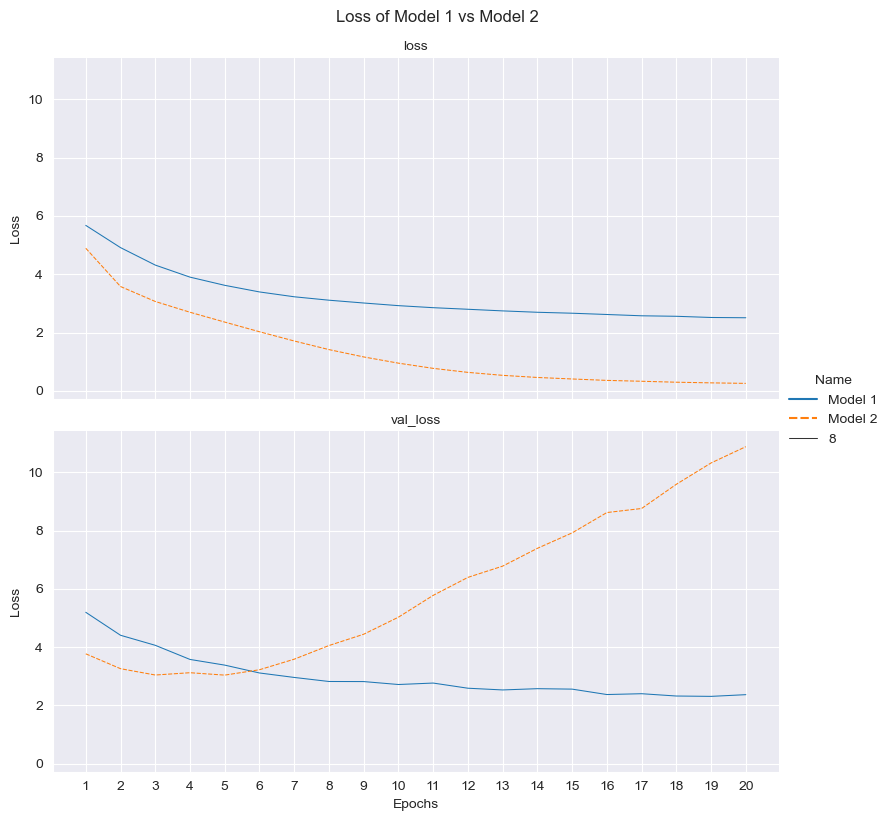

In [89]:
sns.set_style("darkgrid")
g = sns.relplot(data=melted.query('variable == "loss" or variable == "val_loss"'), \
                x="Epochs", y="value", hue="Name", kind="line", height=4, aspect=2, \
                row="variable", style="Name")
g.fig.suptitle("Loss of Model 1 vs Model 2", y=1.02)
g.set(xlabel="Epochs", ylabel="Loss", xticks=range(1,21))
g.set_titles("{row_name}");

In [122]:
def plot_history_comparisons(dfs:list, metrics:str):
    """
    Compare one performance metric between 2 or more models
    """
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(nrows=len(dfs), figsize=(12,7), gridspec_kw={"hspace":.5})
    for idx, df in enumerate(dfs):
        sns.lineplot(data=df, x="Epochs", y=metrics, ax=ax[idx], label=f"Train {metrics.title()}")
        sns.lineplot(data=df, x="Epochs", y=f"val_{metrics}", ax=ax[idx], label= f"Validation {metrics.title()}",\
                    linestyle="--")
        
        ax[idx].set_title(f"Training vs Validation {metrics.title()} for {df['Name'][0]}")
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_xticks(range(1,21))
        if metrics == "loss":
            ax[idx].set_ylabel(f"{metrics.title()} (Categorical Crossentropy)")
        else:
            ax[idx].set_ylabel(f"{metrics.title()}")
        ax[idx].legend()

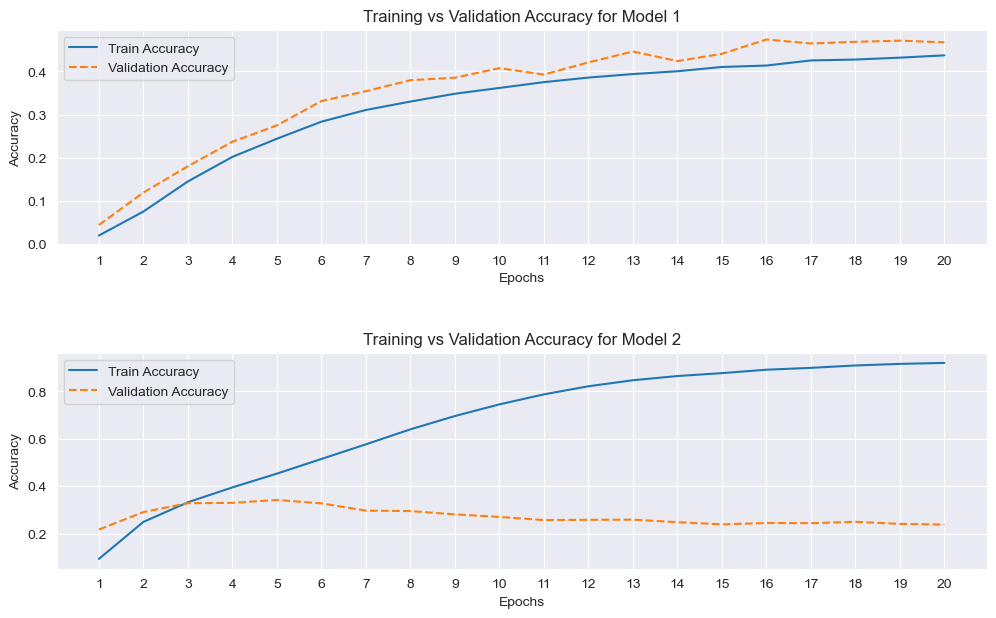

In [123]:
# Plot both metrics for both dfs -> accuracy first
plot_history_comparisons([first_model, model_df], metrics='accuracy')

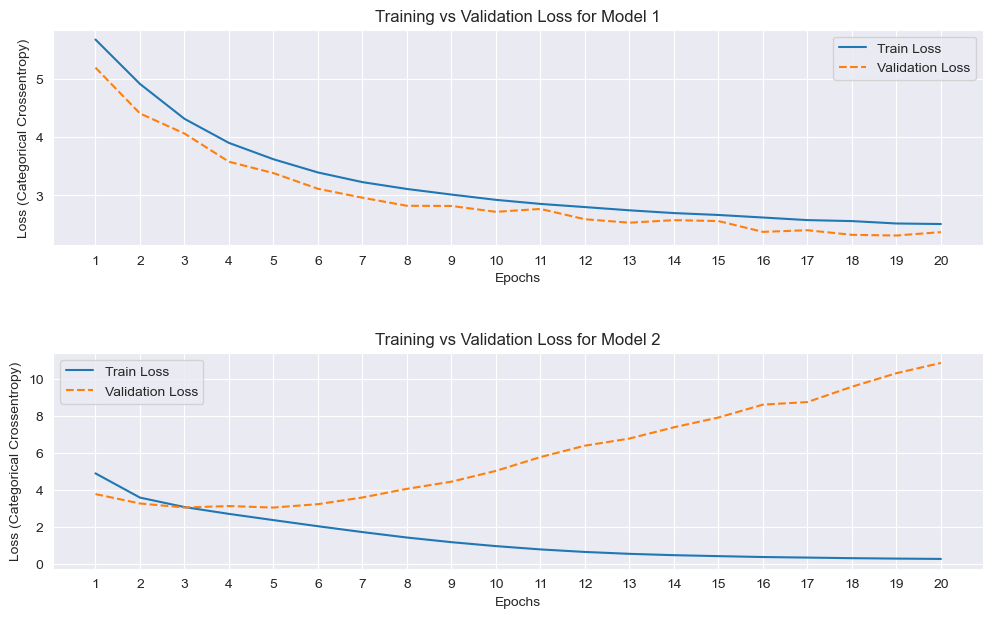

In [124]:
# Loss plot for both models
plot_history_comparisons([first_model, model_df], metrics='loss')

As you can see, the second model exhibits all of the characteristics of being over-fit. There is a huge divergence between training metrics and validation metrics. Where the first model never achieved an adequate level of accuracy, it was able to generalize on par with its training accuracy. It is conceivable that if the first model was allowed to train for many more epochs, perhaps it could have attained more respectable levels of accuracy, as the efficient net solution at the bottom of this notebook was trained over 150 epochs. Regardless, additional tuning is required.

<hr style="border:4px solid blue">

### Third model creation

In [15]:
# Define custom functions for precision, recall, and F1-score

def precision(y_true, y_pred):
    precision = Precision()
    precision.update_state(y_true, y_pred)
    return precision.result()

def recall(y_true, y_pred):
    recall = Recall()
    recall.update_state(y_true, y_pred)
    return recall.result()

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    return 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))

In [19]:
# Third model composition

model3 = Sequential()

model3.add(Conv2D(filters=16, kernel_size=(2,2), strides=1, input_shape=(224,224,3), activation="relu"))
model3.add(MaxPooling2D())

model3.add(Conv2D(filters=12, kernel_size=(2,2), strides=1, activation="relu"))
model3.add(MaxPooling2D())

# This is the first model with a 3rd convolutional layer
model3.add(Conv2D(filters=8, kernel_size=(2,2), strides=1, activation="relu"))
model3.add(MaxPooling2D())

# This is the first model with a 4th convolutional layer
model3.add(Conv2D(filters=8, kernel_size=(2,2), strides=1, activation="relu"))
model3.add(MaxPooling2D())

model3.add(Flatten())
model3.add(Dense(124, activation="relu"))
model3.add(Dense(525, activation="softmax"))

# Model Compilation

model3.compile(optimizer="adam", loss="categorical_crossentropy", \
              metrics=["accuracy"])

In [20]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 223, 223, 16)      208       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 110, 110, 12)      780       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 55, 55, 12)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 54, 54, 8)         392       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 27, 27, 8)       

In [21]:
# Training the model

history_3 = model3.fit(train_generator, epochs=20, validation_data=valid_generator, workers=6)

Epoch 1/20
2645/2645 [==============================] - 750s 283ms/step - loss: 4.8968 - accuracy: 0.1073 - val_loss: 3.6216 - val_accuracy: 0.2499
Epoch 2/20
2645/2645 [==============================] - 763s 289ms/step - loss: 3.4233 - accuracy: 0.2905 - val_loss: 3.0501 - val_accuracy: 0.3459
Epoch 3/20
2645/2645 [==============================] - 1391s 526ms/step - loss: 2.9255 - accuracy: 0.3750 - val_loss: 2.6606 - val_accuracy: 0.4103
Epoch 4/20
2645/2645 [==============================] - 1449s 548ms/step - loss: 2.6256 - accuracy: 0.4263 - val_loss: 2.5570 - val_accuracy: 0.4370
Epoch 5/20
2645/2645 [==============================] - 797s 301ms/step - loss: 2.4156 - accuracy: 0.4625 - val_loss: 2.5003 - val_accuracy: 0.4514
Epoch 6/20
2645/2645 [==============================] - 780s 295ms/step - loss: 2.2570 - accuracy: 0.4911 - val_loss: 2.4193 - val_accuracy: 0.4655
Epoch 7/20
2645/2645 [==============================] - 3178s 1s/step - loss: 2.1293 - accuracy: 0.5155 - val_

In [21]:
# Dataframe for 3rd model metrics

# model3_df = pd.DataFrame(history_3.history)
# model3_df["Epochs"] = range(1, 21)
# model3_df["Name"] = "Model 3"

# model3_df.to_csv("/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_3_logs.csv")
model3_df = pd.read_csv("/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_3_logs.csv", index_col=0)
model3_df.head()

,loss,accuracy,val_loss,val_accuracy,Epochs,Name
0,4.8968,0.1073,3.6216,0.2499,1,Model 3
1,3.4233,0.2905,3.0501,0.3459,2,Model 3
2,2.9255,0.3750,2.6606,0.4103,3,Model 3
3,2.6256,0.4263,2.5570,0.4370,4,Model 3
4,2.4156,0.4625,2.5003,0.4514,5,Model 3


In [131]:
def compare_models_same_plot(dfs:list, metrics=["accuracy", "loss"], train_only=False, val_only=False):
    # Style options
    palette = ["red", "green", "darkorange", "blue"]
    sns.set_style("darkgrid")
    
    # Figure Creation
    fig, ax = plt.subplots(nrows=len(metrics), figsize=(12,9), gridspec_kw={"hspace":.3})
    
    # Loop creating separate plots for accuracy and loss
    for idx, m in enumerate(metrics):
        for i, df in enumerate(dfs):
            # Selecting polar opposite colors to compare models
            color = palette[0 - i]
            
            # Plot train/val for each model df in the loop
            if not val_only:
                sns.lineplot(data=df, x="Epochs", y=m, ax=ax[idx], \
                             label=f"Train {m.title()} for {dfs[i]['Name'][0]}", c=color)
            if not train_only:
                sns.lineplot(data=df, x="Epochs", y=f"val_{m}", ax=ax[idx], \
                             label=f"Validation {m.title()} for {dfs[i]['Name'][0]}", c=color, linestyle="--")
        
        # After completing the loop, format the subplot appropriately
        ax[idx].set_title(f"Training and Validation {m.title()} for {dfs[0]['Name'][0]} vs {dfs[1]['Name'][0]}")
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_xticks(range(1,21))
        if m == "loss":
            ax[idx].set_ylabel(f"{m.title()} (Categorical Crossentropy)")
        else:
            ax[idx].set_ylabel(f"{m.title()}")
        ax[idx].legend()
    names = [dfs[i]["Name"][0] for i in range(len(dfs)-1)]
    if len(names) > 1:
        names = " vs ".join(names)
    else:
        names = " ".join(names)
    plt.suptitle(f"Comparison of {names} vs {dfs[-1]['Name'][0]}", y=.95, fontsize=18)

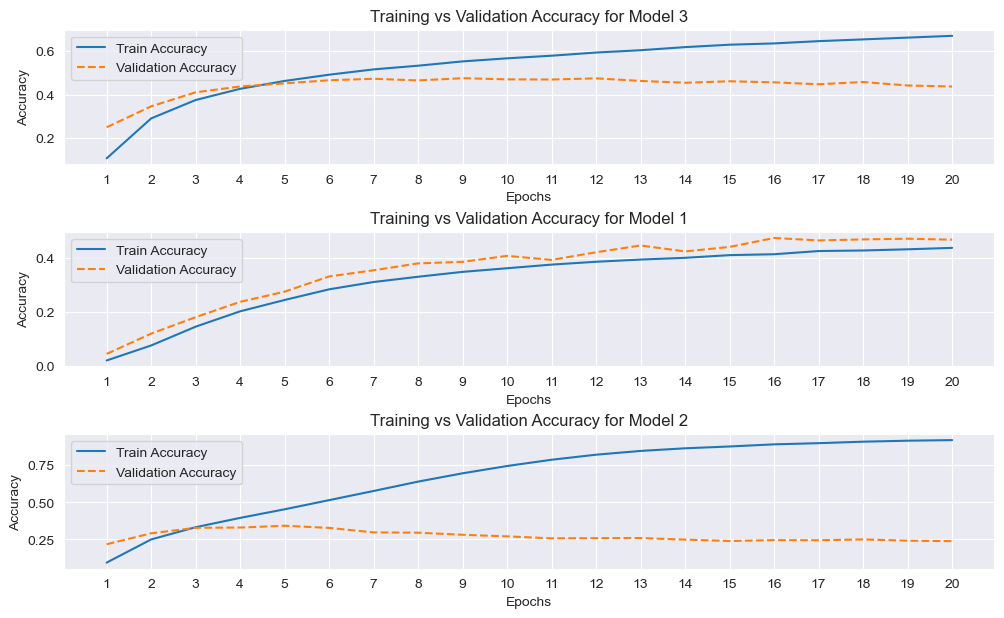

In [132]:
plot_history_comparisons([model3_df, first_model, model_df], "accuracy")

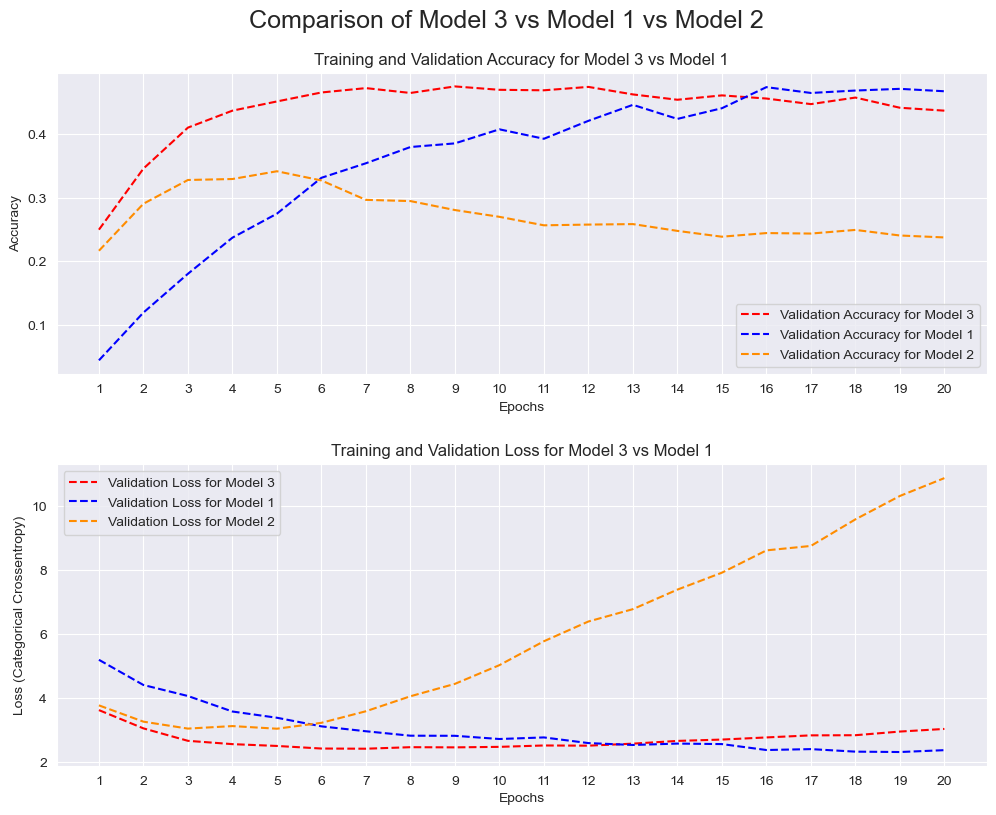

In [137]:
compare_models_same_plot([model3_df, first_model, model_df], val_only=True, train_only=False)

<hr style="border:4px solid blue">

### Model 4 with Weights and Biases

In [9]:
model4 = Sequential()

# Input block
model4.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=(224,224,3), activation="relu"))
model4.add(BatchNormalization())

# 2nd block
model4.add(Conv2D(filters=16, kernel_size=(2,2), strides=1, activation="relu"))
model4.add(MaxPooling2D())

# 3rd block
model4.add(Conv2D(filters=8, kernel_size=(2,2), strides=1, activation="relu"))
model4.add(BatchNormalization())

# 4th block
model4.add(Conv2D(filters=32, kernel_size=(2,2), strides=1, activation="relu"))
model4.add(MaxPooling2D())

#5th block
model4.add(Conv2D(filters=8, kernel_size=(2,2), strides=1, activation="relu"))
model4.add(MaxPooling2D())

# Output block
model4.add(Flatten())
model4.add(Dense(124, activation="relu"))
model4.add(Dense(525, activation="softmax"))

# Model Compilation

model4.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 221, 221, 16)      2064      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 16)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 109, 109, 8)       520       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 8)     

In [12]:
# 4th Model, adding weights and biases callback for model log tracking

wandb.init(
    # Title the project
    project="Bird Species Classification",
    
    # Record the setup of the network
    config={"architecture":"CNN",
            "dataset":"Kaggle 525 Species Classification",
            "epochs":20,
            "blocks":6,
            "pre-processing":"scaling(1/255)",
            "typical_block_composition":["input_cnn", "BatchNorm"],
            "final_block":["maxpool, flatten, dense, dense_output"]
}
          )

# Fourth model composition

model4 = Sequential()

# Input block
model4.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=(224,224,3), activation="relu"))
model4.add(BatchNormalization())

# 2nd block
model4.add(Conv2D(filters=16, kernel_size=(2,2), strides=1, activation="relu"))
model4.add(MaxPooling2D())

# 3rd block
model4.add(Conv2D(filters=8, kernel_size=(2,2), strides=1, activation="relu"))
model4.add(BatchNormalization())

# 4th block
model4.add(Conv2D(filters=32, kernel_size=(2,2), strides=1, activation="relu"))
model4.add(MaxPooling2D())

#5th block
model4.add(Conv2D(filters=8, kernel_size=(2,2), strides=1, activation="relu"))
model4.add(MaxPooling2D())

# Output block
model4.add(Flatten())
model4.add(Dense(124, activation="relu"))
model4.add(Dense(525, activation="softmax"))

# Model Compilation

model4.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history_4 = model4.fit(train_generator, epochs=20, validation_data=valid_generator, workers=6,\
                       callbacks=[WandbCallback()])

wandb.finish()

Epoch 1/20
2057/2645 [======================>.......] - ETA: 16:57 - loss: 5.4221 - accuracy: 0.0372

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, GlobalAveragePooling2D, \
Reshape, Dense, Activation, BatchNormalization, Add, Multiply

from tensorflow.keras.models import Sequential

def squeeze_excite_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se_shape = (1, 1, channels)

    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(channels // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([input_tensor, se])
    return x

model = Sequential()

# Input block
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, input_shape=(224, 224, 3), activation="relu"))
model.add(BatchNormalization())

# Depthwise separable convolutions
model.add(DepthwiseConv2D(kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(1, 1), strides=1, padding='same', activation=None))
model.add(BatchNormalization())

# Squeeze-and-Excitation block
model.add(squeeze_excite_block(model.output))

# MaxPooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Repeat similar blocks as desired

# Output block
model.add(Flatten())
model.add(Dense(124, activation="relu"))
model.add(Dense(525, activation="softmax"))

model.summary()

<hr style="border:4px solid blue">

### Examining the model provided via kaggle

In [53]:
from tensorflow.keras.models import load_model

provided_model = load_model('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/EfficientNetB0-525-(224 X 224)- 98.97.h5',
                           custom_objects={"F1_score":"F1_score"})

# Unknown metric function: F1_score. Please ensure this object is passed to the `custom_objects` argument. 
# See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

# model= keras.models.load_model(model_path, custom_objects={'F1_score':'F1_score'})


# rescaling (Rescaling) -> typically redundant given the rescale=1/255 argument of ImageDataGenerator

# normalization: 
"""
So, if you have already scaled your data using the rescale parameter in the ImageDataGenerator, 
applying the Normalization layer with default settings (using the computed mean and standard deviation during 
training) would effectively perform a z-score normalization on the already scaled data. Depending on your 
specific use case and preference, you can choose to use either approach or decide whether additional normalization 
is necessary based on your data and model requirements.
"""



In [54]:
provided_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0][0]']      

                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 48)  192         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_add (Add)              (None, 28, 28, 48)   0           ['block3b_project_bn[0][0]',     
                                                                  'block3a_project_bn[0][0]']     
                                                                                                  
 block4a_expand_conv (Conv2D)   (None, 28, 28, 192)  9216        ['block3b_add[0][0]']            
                                                                                                  
 block4a_e

                                                                                                  
 block4c_expand_activation (Act  (None, 14, 14, 384)  0          ['block4c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4c_dwconv2 (DepthwiseConv  (None, 14, 14, 384)  3456       ['block4c_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, 14, 14, 384)  1536       ['block4c_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4c_a

                                                                                                  
 block5b_se_squeeze (GlobalAver  (None, 672)         0           ['block5b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5b_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5b_se_squeeze[0][0]']     
                                                                                                  
 block5b_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_s

                                                                                                  
 block5d_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5d_activation[0][0]',     
                                                                  'block5d_se_expand[0][0]']      
                                                                                                  
 block5d_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_add (Add)              (None, 14, 14, 112)  0           ['block5d_project_bn[0][0]',     
          

 block6b_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6a_project_bn[0][0]']     
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6b_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6b_dwconv2 (DepthwiseConv  (None, 7, 7, 1152)  10368       ['block6b_expand_activation[0][0]
 2D)                                                             ']                               
          

 2D)                                                             ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6d_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 7, 7, 1152)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
          

 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6f_activation[0][0]',     
                                                                  'block6f_se_expand[0][0]']      
          

                                                                  'block6h_se_expand[0][0]']      
                                                                                                  
 block6h_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6h_se_excite[0][0]']      
                                                                                                  
 block6h_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6h_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6h_add (Add)              (None, 7, 7, 192)    0           ['block6h_project_bn[0][0]',     
                                                                  'block6g_add[0][0]']            
                                                                                                  
 top_conv 

In [120]:
batch = test_generator.next()
np.argmax(batch[1][0])

16

In [122]:
test_preds = provided_model.predict(batch[0])

1/1 [==============================] - 1s 722ms/step


In [123]:
batch[0].shape

(32, 224, 224, 3)

In [124]:
test_preds[0].shape, len(test_preds)

((525,), 32)

In [125]:
# Extremely high confidence
test_preds[0].max()

0.9821244

In [126]:
np.argmax(test_preds[0])

16

In [127]:
preds = []
for i in test_preds:
    preds.append(np.argmax(i))

In [128]:
preds

[16,
 144,
 23,
 123,
 25,
 390,
 161,
 298,
 309,
 174,
 369,
 301,
 326,
 91,
 205,
 33,
 24,
 467,
 208,
 323,
 441,
 267,
 2,
 100,
 291,
 88,
 115,
 517,
 265,
 178,
 220,
 191]

In [129]:
true_values = []
for i in batch[1]:
    true_values.append(np.argmax(i))

In [132]:
true_values 

[16,
 144,
 23,
 123,
 25,
 390,
 161,
 298,
 309,
 174,
 369,
 301,
 326,
 91,
 205,
 33,
 478,
 467,
 208,
 323,
 441,
 267,
 2,
 100,
 291,
 88,
 115,
 517,
 265,
 178,
 220,
 191]

In [133]:
list(zip(true_values, preds))

[(16, 16),
 (144, 144),
 (23, 23),
 (123, 123),
 (25, 25),
 (390, 390),
 (161, 161),
 (298, 298),
 (309, 309),
 (174, 174),
 (369, 369),
 (301, 301),
 (326, 326),
 (91, 91),
 (205, 205),
 (33, 33),
 (478, 24),
 (467, 467),
 (208, 208),
 (323, 323),
 (441, 441),
 (267, 267),
 (2, 2),
 (100, 100),
 (291, 291),
 (88, 88),
 (115, 115),
 (517, 517),
 (265, 265),
 (178, 178),
 (220, 220),
 (191, 191)]

In [135]:
reverse_dict[478], reverse_dict[24]

('TEAL DUCK', 'AMERICAN WIGEON')

In [ ]:
classification_report(test_generator)

### Check predictions/classifcation report for the provided model whenever you feel like it. 